In [1]:
# pip install git+https://www.github.com/gezzze/pydwd@testing

# Remove old files
- dwd_data

In [1]:
import pathlib

# Function to remove files and folders 
def delete_folder(pth) :
    for sub in pth.iterdir() :
        if sub.is_dir():
            delete_folder(sub)
        else :
            sub.unlink()
    pth.rmdir()
    
delete_folder(pathlib.Path('dwd_data'))

# Import modules necessary for general functioning


In [2]:
# Modules used
try:
    import python_dwd
except:
    import sys
    sys.path.append("..")

    import python_dwd

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from python_dwd.enumerations.period_type_enumeration import PeriodType
from python_dwd.enumerations.time_resolution_enumeration import TimeResolution
from python_dwd.enumerations.parameter_enumeration import Parameter

## 1. First check of a metadatafile
- for daily climate historical file
- metadata is printed with its shape/size and the number of available stations

In [3]:
metadata_precip_daily = python_dwd.metadata_for_dwd_data(parameter=Parameter.PRECIPITATION_MORE,
                                                         time_resolution=TimeResolution.DAILY,
                                                         period_type=PeriodType.HISTORICAL)
print("Size of dataframe: ", metadata_precip_daily.shape)
print("Number of available stations: ", metadata_precip_daily[metadata_precip_daily.HAS_FILE == True].shape[0])
metadata_precip_daily.head()

Size of dataframe:  (5945, 9)
Number of available stations:  5930


,STATION_ID,FROM_DATE,TO_DATE,STATIONHEIGHT,LAT,LON,STATIONNAME,STATE,HAS_FILE
0,1,1912-01-01,1986-06-30,478.0,47.8413,8.8493,Aach,Baden-Württemberg,True
1,2,1951-01-01,2006-12-31,138.0,50.8066,6.0996,Aachen (Kläranlage),Nordrhein-Westfalen,True
2,3,1891-01-01,2011-03-31,202.0,50.7827,6.0941,Aachen,Nordrhein-Westfalen,True
3,4,1951-01-01,1979-10-31,243.0,50.7683,6.1207,Aachen-Brand,Nordrhein-Westfalen,True
4,6,1982-11-01,2019-10-01,455.0,48.8361,10.0598,Aalen-Unterrombach,Baden-Württemberg,True


In [4]:
metadata_precip_1min = python_dwd.metadata_for_dwd_data(parameter=Parameter.PRECIPITATION, 
                                                   time_resolution=TimeResolution.MINUTE_1, 
                                                   period_type=PeriodType.HISTORICAL)
print("Size of dataframe: ", metadata_precip_1min.shape)
print("Number of available stations: ", metadata_precip_1min[metadata_precip_1min.HAS_FILE == True].shape)
metadata_precip_1min.head()

 54%|█████▎    | 605/1130 [04:19<04:55,  1.77it/s]

The metadata includes an id, the range of the measurments, the position  (including height) as well as place and state of it and if it has a file. With the following plot we want to show a map of those stations:

Text(0.5, 1.0, 'Map of daily precipitation stations in Germany\nColor refers to height of station')

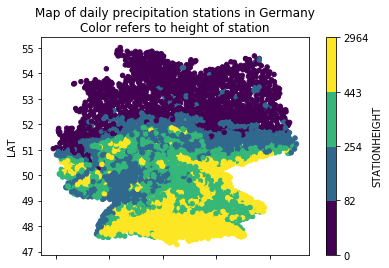

In [20]:
from matplotlib import cm
cmap = cm.get_cmap('viridis')
bounds = metadata_precip_daily.STATIONHEIGHT.quantile([0, 0.25, 0.5, 0.75, 1]).values
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

plot = metadata_precip_daily.plot.scatter(x="LON", y="LAT", c="STATIONHEIGHT", cmap=cmap, norm=norm)
plot.set_title("Map of daily precipitation stations in Germany\nColor refers to height of station")

## 2. The usual way of retrieving data

We first select our station with select_dwd as chosen from the above metadata by:
- it's id and
    * 1048 for Dresden, Germany 
- the composition of parameters
    * var="kl" for climate
    * res="daily" for daily data
    * per="historical" for data of all time

In [3]:
# Receive data for Dresden-Klotzsche (STATION_ID 1048)
# Link
remote_file_path = python_dwd.create_file_list_for_dwd_server(statid=[1048],
                                                              parameter=Parameter.CLIMATE_SUMMARY,
                                                              time_resolution=TimeResolution.DAILY,
                                                              period_type=PeriodType.HISTORICAL) 
remote_file_path

,FILEID,STATION_ID,FILENAME
209,212,1048,daily/kl/historical/tageswerte_KL_01048_193401...


The function returns a link which leads to the server path where we can find the file. It is downloaded with download_dwd and the link from above:

In [4]:
# Download
station_download = python_dwd.download_dwd_data(remote_file_path)

The returned link now leads to the local file. Next we read it in with read_dwd et voila, the function presents us a DataFrame with first values.

In [5]:
station_data = python_dwd.parse_dwd_data(station_download)
station_data.head()

,STATION_ID,DATE,QN_3,FX,FM,QN_4,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,TMK,UPM,TXK,TNK,TGK,EOR
0,1048,1934-01-01,NaN,NaN,NaN,1,0.2,8.0,NaN,0.0,8.0,6.4,1008.6,0.5,97.0,0.7,0.2,NaN,eor
1,1048,1934-01-02,NaN,NaN,NaN,1,0.1,7.0,NaN,0.0,8.0,5.9,1006.2,-0.1,90.0,0.9,-0.8,NaN,eor
2,1048,1934-01-03,NaN,NaN,NaN,1,0.0,0.0,NaN,0.0,8.0,5.2,1001.6,-0.7,85.0,-0.1,-1.0,NaN,eor
3,1048,1934-01-04,NaN,NaN,NaN,1,0.0,1.0,NaN,0.0,8.0,4.8,1001.4,-1.6,82.0,-0.3,-3.5,NaN,eor
4,1048,1934-01-05,NaN,NaN,NaN,1,10.1,8.0,NaN,0.0,5.3,6.3,996.0,0.9,92.0,2.8,-3.8,NaN,eor


See that DATE is already parsed, so we can easily get some nice graphs with matplotlib.

## 3. Let's create some plots

First to have an easier job with the data, we want it to be transformed from tabular to column data, which means instead of having the data in several columns with an additional date column, we want three columns, where a set of all three defines the date of measured data, element and the exact value. To make it clear look at the following table, which is already transformed.

In [9]:
id_vars = ["STATION_ID", "DATE"]
value_vars = station_data.columns
value_vars = [var for var in value_vars if var not in id_vars]
station_data_transformed = station_data.melt(id_vars=id_vars, value_vars=value_vars, var_name="ELEMENT", value_name="VALUE")

station_data_transformed.head()

,STATION_ID,DATE,ELEMENT,VALUE
0,1048,1934-01-01,QN_3,NaN
1,1048,1934-01-02,QN_3,NaN
2,1048,1934-01-03,QN_3,NaN
3,1048,1934-01-04,QN_3,NaN
4,1048,1934-01-05,QN_3,NaN


* we can create a timeseries/histogram of some elements to compare the distribution of the values, here for example precipitation and mean temperature:

In [10]:
elements_to_plot = ["RSK", "TMK"]
station_data_filtered = station_data_transformed.loc[station_data_transformed["ELEMENT"].isin(elements_to_plot)].sort_values(["STATION_ID", "ELEMENT", "DATE"])
# station_data_filtered.groupby("ELEMENT")["VALUE"].plot.hist()

station_data_grouped = station_data_filtered.groupby("ELEMENT")["DATE", "VALUE"] #.plot(x="DATE", y="VALUE")

Text(0.5, 0.98, 'Precipitation/Mean temperature timeseries of Dresden, Germany')

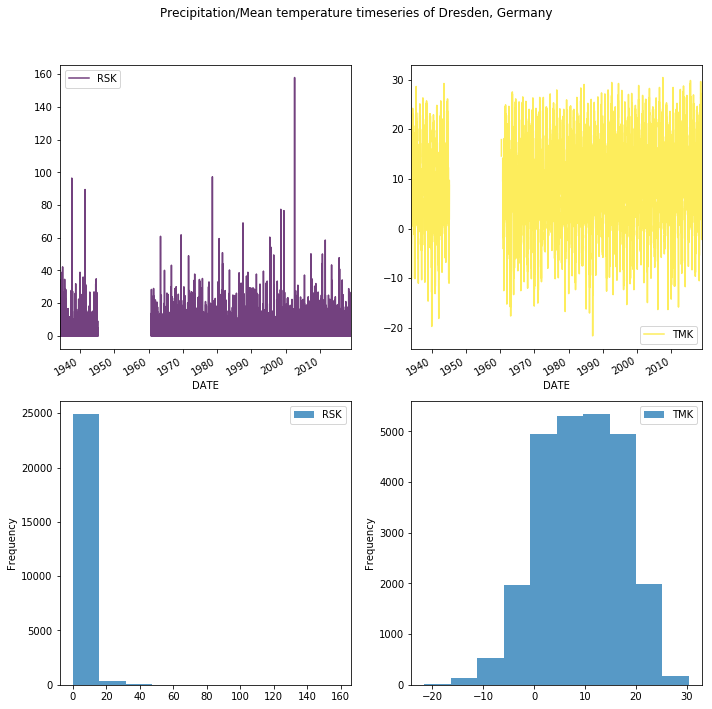

In [11]:
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, 2))

fig, axes = plt.subplots(len(elements_to_plot), len(elements_to_plot), figsize=(10, 10))

for (k, v), (ax1, ax2), color in zip(station_data_grouped, axes.T, colors):
    v.plot(x="DATE", y="VALUE", label=k, alpha=.75, ax=ax1, c=color)
    v.plot(y="VALUE", kind="hist", label=k, alpha=.75, ax=ax2)
    
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle("Precipitation/Mean temperature timeseries of Dresden, Germany")

We can see here that the precipitation is completely left-skewed and not normal distributed, while the temperature is almost normaldistributed! Also the timeseries gives a glimpse on how much data is available! Sad notice here is the gap of WW2.

## 4. Create yearly values

In [5]:
python_dwd.get_nearest_station([51.05089], [13.73832], Parameter.CLIMATE_SUMMARY, TimeResolution.DAILY, PeriodType.HISTORICAL)

([1047], [1.3268238814030275])